In [ ]:
!pip uninstall tensorflow

!pip install tensorflow==2.2.0

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 27kB/s 
     |████████████████████████████████| 460kB 49.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from keras.preprocessing import text, sequence
from keras import backend as K
from keras import utils
from keras.models import Sequential
from keras.layers import Dense,GRU,Embedding,SpatialDropout1D,LSTM,Bidirectional,Dropout,BatchNormalization
from keras.utils import to_categorical
from numpy import argmax
import matplotlib.pyplot as plt
import itertools
from keras import optimizers, regularizers
from sklearn.preprocessing import OneHotEncoder

In [2]:
print(tf.__version__)

2.3.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cols = ['TITLE','RATING']
#data = pd.read_csv('/content/drive/My Drive/TFM/data/imdb_data.csv',header=0,decimal=',',usecols=cols)
data = pd.read_csv("/content/drive/My Drive/Máster KSchool/TFM/data/imdb_data.csv",header=0,decimal=',',usecols=cols)

In [5]:
data['RATING']  = data['RATING'].astype(float)
data['RATING_CAT'] = pd.cut(data['RATING'], bins = [0,5,6.5,10], labels=['0','1','2'])
data.head(3)

,TITLE,RATING,RATING_CAT
0,Love Beats Rhymes,5.3,1
1,Mass,6.4,1
2,Vicky el vikingo,5.5,1


In [6]:
print(len(data[data['RATING_CAT']=='0']))
print(len(data[data['RATING_CAT']=='2']))
print(len(data[data['RATING_CAT']=='1']))

11130
22331
26164


In [7]:
X = data['TITLE'].values
y = np.array(data['RATING_CAT'].values)
y = y.reshape(-1, 1)

In [8]:
ency = OneHotEncoder(handle_unknown='ignore', sparse = False)
ency.fit(y)
y_one_hot = ency.transform(y)

In [9]:
 train_texts, tests_texts, train_labels, test_labels = train_test_split(X, y_one_hot, test_size=0.2, random_state=22, shuffle = True, stratify=y_one_hot)

In [10]:
print("train_texts shape",train_texts.shape)
print("train_labels shape",train_labels.shape)
print("test_texts shape",tests_texts.shape)
print("test_labels shape",test_labels.shape)

train_texts shape (47700,)
train_labels shape (47700, 3)
test_texts shape (11925,)
test_labels shape (11925, 3)


In [11]:
tokenizer = text.Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(train_texts) 

In [12]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [13]:
max_lenght = 30

X_train = tokenizer.texts_to_sequences(train_texts)
X_test =  tokenizer.texts_to_sequences(tests_texts)

X_train = sequence.pad_sequences(X_train, maxlen=max_lenght)
X_test = sequence.pad_sequences(X_test, maxlen=max_lenght)


y_train = train_labels
y_test = test_labels


print('X_train shape:', X_train.shape)
print('X_test shape', X_test.shape)


X_train shape: (47700, 30)
X_test shape (11925, 30)


In [14]:
word_index = tokenizer.word_index
print('Numero de tokens:',len(word_index))
word_count = tokenizer.word_counts

print("Tokens mas frecuentes:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=True)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 9: 
        print('')
        break
print("Tokens menos frecuentes:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=False)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 9: 
        print('')
        break

Numero de tokens: 36916
Tokens mas frecuentes:
   de (5130) --> 1
   la (4721) --> 2
   el (4290) --> 3
   the (3998) --> 4
   a (1518) --> 5
   del (1511) --> 6
   en (1458) --> 7
   los (1353) --> 8
   of (1272) --> 9
   un (992) --> 10

Tokens menos frecuentes:
   reggie (1) --> 12086
   mixes (1) --> 12087
   weiãƒå¸e (1) --> 12088
   levoton (1) --> 12089
   veri (1) --> 12090
   b'shikun (1) --> 12091
   gimel (1) --> 12092
   ejareh (1) --> 12093
   nesheenha (1) --> 12094
   nameless (1) --> 12095



In [15]:
oov = ['aaaa', 'bbbbbbbbb']  #Comportamiento ante palabras fuera del vocabulario
sequences = tokenizer.texts_to_matrix(oov)
print(sequences[0][:10])
print(any(x == 1 for x in sequences[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False


In [16]:
epochs = 25
batch_size = 128
embedding_dim = 300
classes = 3

CREAMOS UNA MÉTRICA

In [17]:
def recall_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    recall_mask = K.cast(K.equal(class_id_true, class_id), 'int32')
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)

    return class_recall

def precision_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    precision_mask = K.cast(K.equal(class_id_preds, class_id), 'int32')
    class_prec_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * precision_mask
    class_prec = K.sum(class_prec_tensor) / K.maximum(K.sum(precision_mask), 1)

    return class_prec
  
def f1_class(y_true, y_pred,class_id):

    class_prec = precision_class(y_true, y_pred, class_id)
    class_recall = recall_class(y_true, y_pred, class_id)
    class_f1 = 2*((class_prec*class_recall)/(class_prec+class_recall+K.epsilon()))

    return class_f1

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def custom_metric(y_true, y_pred):
  
  recall_0 = recall_class(y_true, y_pred, 0)
  f1_1 = f1_class(y_true, y_pred,1)
  precision_2 = precision_class(y_true, y_pred, 2)
  total_precision = precision(y_true, y_pred)

  metric = ((recall_0 + f1_1 + precision_2)/3)
  return metric

In [18]:
weights = {0:10, 1:6, 2:8}

In [21]:

model = Sequential()
model.add(Embedding(10000, embedding_dim, input_length=X_train.shape[1]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(Bidirectional(LSTM(256,recurrent_dropout=0.1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(126, activation='relu'))
model.add(tf.keras.layers.Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',custom_metric])



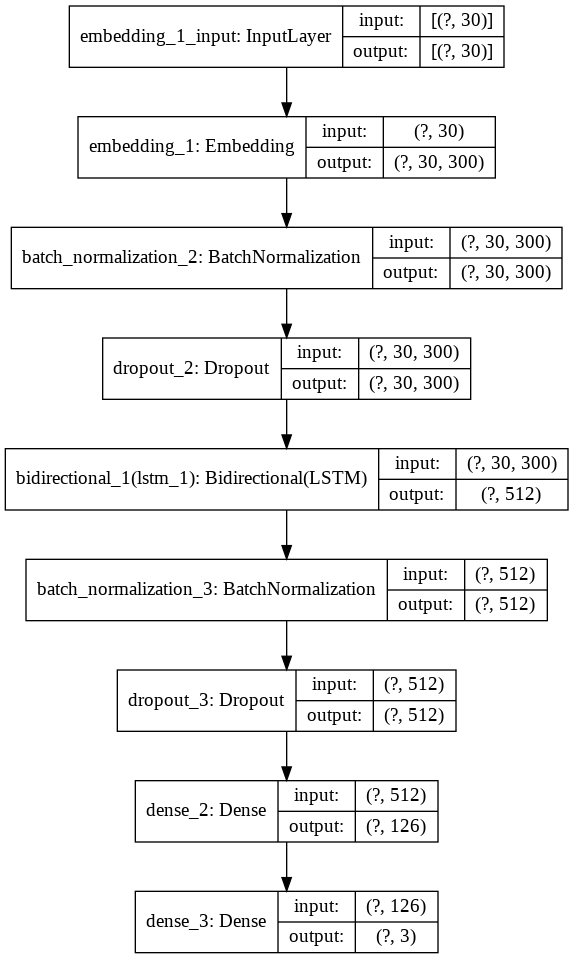

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image as printModel
plot_model(model, to_file='Multiinput.png',show_shapes=True,show_layer_names=True)
printModel(retina=True, filename='Multiinput.png')

In [24]:
plt.savefig('title.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=30, validation_data=(X_test, y_test), verbose=1,class_weight=weights)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'custom_metric', 'val_loss', 'val_accuracy', 'val_custom_metric'])


dict_keys(['loss', 'accuracy', 'custom_metric', 'val_loss', 'val_accuracy', 'val_custom_metric'])


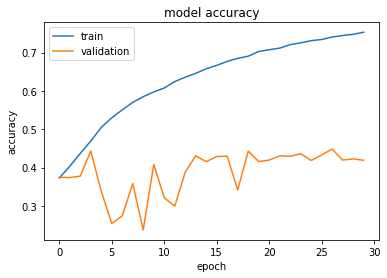

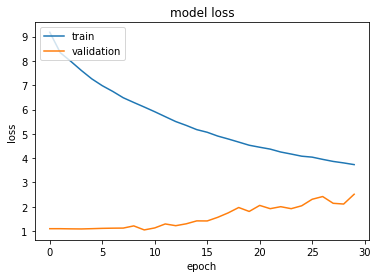

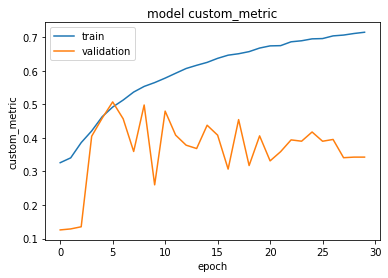

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['custom_metric'])
plt.plot(history.history['val_custom_metric'])
plt.title('model custom_metric')
plt.ylabel('custom_metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred= model.predict([X_test])
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['0-5', '5-6.5', '6.5-10']

Confusion matrix, without normalization
[[ 679 1138  409]
 [ 860 2876 1497]
 [ 501 2423 1542]]


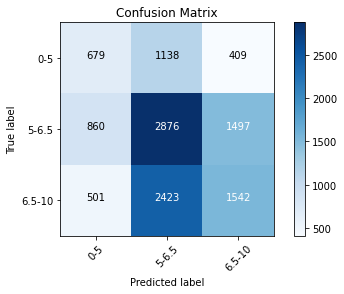

In [ ]:
plot_confusion_matrix(cm=matrix, classes=target_names, title='Confusion Matrix')

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         0-5       0.33      0.31      0.32      2226
       5-6.5       0.45      0.55      0.49      5233
      6.5-10       0.45      0.35      0.39      4466

    accuracy                           0.43     11925
   macro avg       0.41      0.40      0.40     11925
weighted avg       0.43      0.43      0.42     11925



In [ ]:
model.save('/tmp/model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/model/assets
